# makes HBV and leakybucket hydrograph for comparison

for now only Kerki as test

In [14]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [15]:
# The name of the shapefile
shape_file_name = "Kerki"  # river: Bedford Ouse at Roxton, England

# The time-window of the experiment
experiment_start_date = "1990-01-01T00:00:00Z"
experiment_end_date = "1995-12-31T00:00:00Z"

forcing_path_ERA5 = (
    Path.home()
    / "MSc_AralSea"
    / "book"
    / "thesis_projects"
    / "MSc"
    / "2025_Q1_AndreVanDerVeen_CEG"
    / "work_in_progress"
    / "Test_Aral"
    / "forcing_Kerki_HBV_5570"
    / shape_file_name
    / "ERA5"
    / "own_shapefile"
)
# forcing_path_ERA5 = (
#     Path.cwd()
#     / "AralSea_Basin"
#     / "forcing_Kerki"
#     / shape_file_name
#     / "ERA5"
#     / "own_shapefile"
# )


# The path save directory of the ERA5 data
#forcing_path_ERA5 = Path.home() / "projects/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Aral_Test/forcing" / shape_file_name / "ERA5" / "own_shapefile"
#forcing_path_ERA5.mkdir(exist_ok=True)
load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script" 
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)


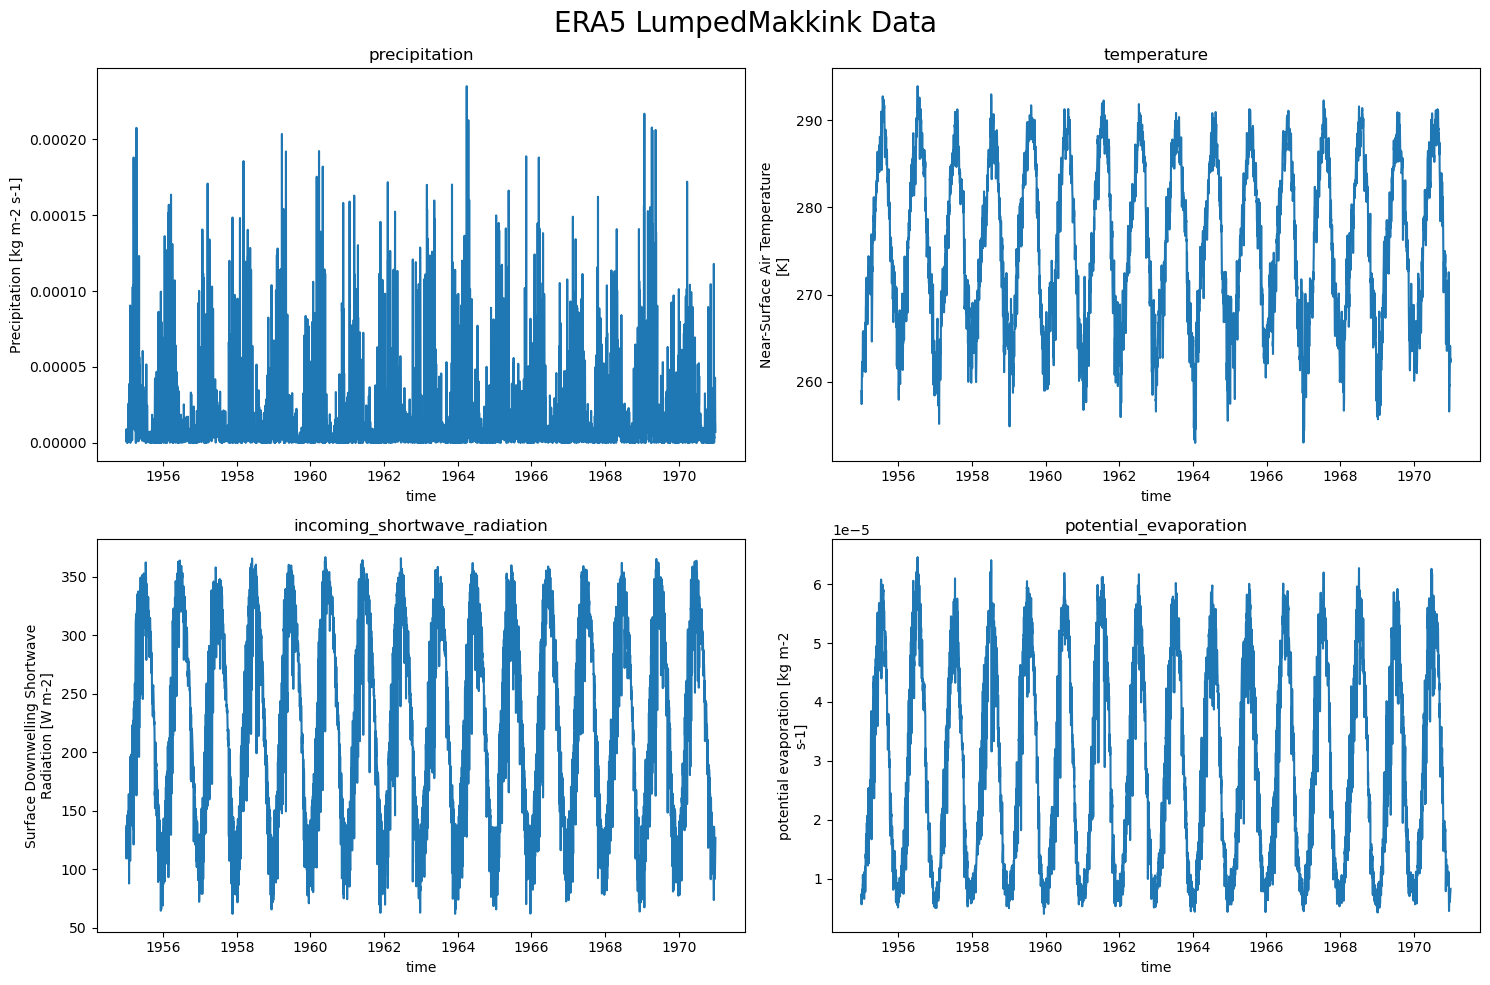

In [29]:
ERA5_data = {'precipitation pr': xr.open_dataset(ERA5_forcing['pr']),
             'temperature tas': xr.open_dataset(ERA5_forcing['tas']),
             'incoming_shortwave_radiation rsds': xr.open_dataset(ERA5_forcing['rsds']),
             'potential_evaporation evspsblpot': xr.open_dataset(ERA5_forcing['evspsblpot'])

             
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for name, data in ERA5_data.items():
    plt.subplot(2,2, plot_counter)
    data[name.split(" ")[-1]].plot()
    plt.title(f"{name.split(" ")[0]}")
    plot_counter += 1

plt.suptitle("ERA5 LumpedMakkink Data", fontsize=20)
plt.tight_layout()

In [17]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)


In [18]:
parameter_set =  [
    7.085,  # Imax
    0.837,  # Ce
    76.373, # Sumax
    1.112,  # Beta
    0.245,  # Pmax
    7.801,  # Tlag
    0.096,  # Kf
    0.003,  # Ks
    0.226   # FM
]

initial_conditions = np.array([
    0,      # Si
    100,    # Su
    0,      # Sf
    5,      # Ss
    0       # Sp
])

In [19]:
config_file, _ = model.setup(parameters=parameter_set, initial_storage=initial_conditions)

In [20]:
model.initialize(config_file)

In [21]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [22]:
# Finalize model (shuts down container, frees memory)
model.finalize()

In [23]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

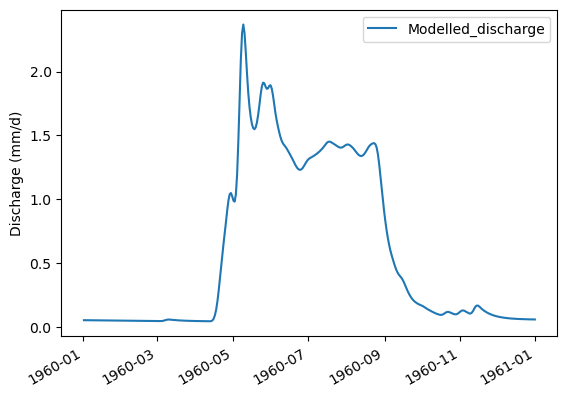

In [26]:
#model_output.plot()

# Filter only year 1997
data_1997 = model_output[model_output.index.year == 1960]

# Plot
data_1997.plot()
#ds_forcing["Q"].plot(label="Observed discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [25]:
# We want to also be able to use the output of this model run in different analyses. Therefore we save it as a NetCDF file
xr_model_output = model_output.to_xarray()

xr_model_output.attrs['units'] = 'mm/d'

# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf(Path.cwd()/'Aral_AmuDarya_Kerki.nc')

In [27]:
xr_model_output

<xarray.DataArray 'Modelled_discharge' (index: 5843)> Size: 47kB
array([0.00049853, 0.00202206, 0.00462608, ..., 0.06134967, 0.06120734,
       0.0610671 ])
Coordinates:
  * index    (index) datetime64[ns] 47kB 1955-01-02T12:00:00 ... 1970-12-31T1...
Attributes:
    units:    mm/d

In [28]:
model_output

1955-01-02 12:00:00    0.000499
1955-01-03 12:00:00    0.002022
1955-01-04 12:00:00    0.004626
1955-01-05 12:00:00    0.008365
1955-01-06 12:00:00    0.012296
                         ...   
1970-12-27 12:00:00    0.061642
1970-12-28 12:00:00    0.061494
1970-12-29 12:00:00    0.061350
1970-12-30 12:00:00    0.061207
1970-12-31 12:00:00    0.061067
Name: Modelled_discharge, Length: 5843, dtype: float64

In [30]:

model_output.to_csv("HBV_Kerki_5961.csv", index=True)

In [ ]:
conversion_mmday2m3s = 1 / (1000 * 86400)
shape = fiona.open(Path.cwd()/"AralSea_Basin/Kerki/Kerki.shp")
poly = [shapely.geometry.shape(p["geometry"]) for p in shape][0]
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(poly)
catchment_area_m2 = abs(poly_area)
print(f"{catchment_area_m2 = }")